# Image Segmentation

## Object detection vs Semantic segmentation vs Instance segmentation
- Object detectioin: This task focuses on identifying objects within an image and drawing bounding boxes around them.Object detection models output a set of bounding boxes along with the class labels and confidence scores for each detected object
- Semantic Segmentation: every pixel in an image is classified into a predefined category, leading to a detailed, pixel-wise map of the image. This method doesn't distinguish between different instances of the same class
- Instance segmentation: This task combines elements of both object detection and semantic segmentation. Like semantic segmentation, instance segmentation classifies each pixel in the image. However, it also differentiates between different instances of the same class. In the case of the three cars, instance segmentation would provide a unique label for each car, allowing individual objects to be distinguished from one another.

## Let's start with Semantic Segmentation!

In [3]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [4]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    random.seed(seed_value)
set_seed(42)

In [5]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [6]:
PATH_DIR = "../data-science-bowl-2018/"
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'
TRAIN_PATH = os.path.join(PATH_DIR, TRAIN_PATH)
TEST_PATH = os.path.join(PATH_DIR, TEST_PATH)

In [11]:
train_ids = next(os.walk(TRAIN_PATH))[1] ## Return the list of dirs
test_ids = next(os.walk(TEST_PATH))[1]

In [13]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [14]:
X_train.shape ## it is an array of 670 images

(670, 128, 128, 3)

In [16]:
'''This returns:
- Fill the images in the X_train array
- Create the mask:
    - iterate over all the masks in a subdir for a given image and update the previous mask computing the maximumn with the current mask!'''
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
    Y_train[n] = mask   

100%|██████████| 670/670 [02:28<00:00,  4.50it/s]


In [17]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:00<00:00, 65.59it/s]

Done!


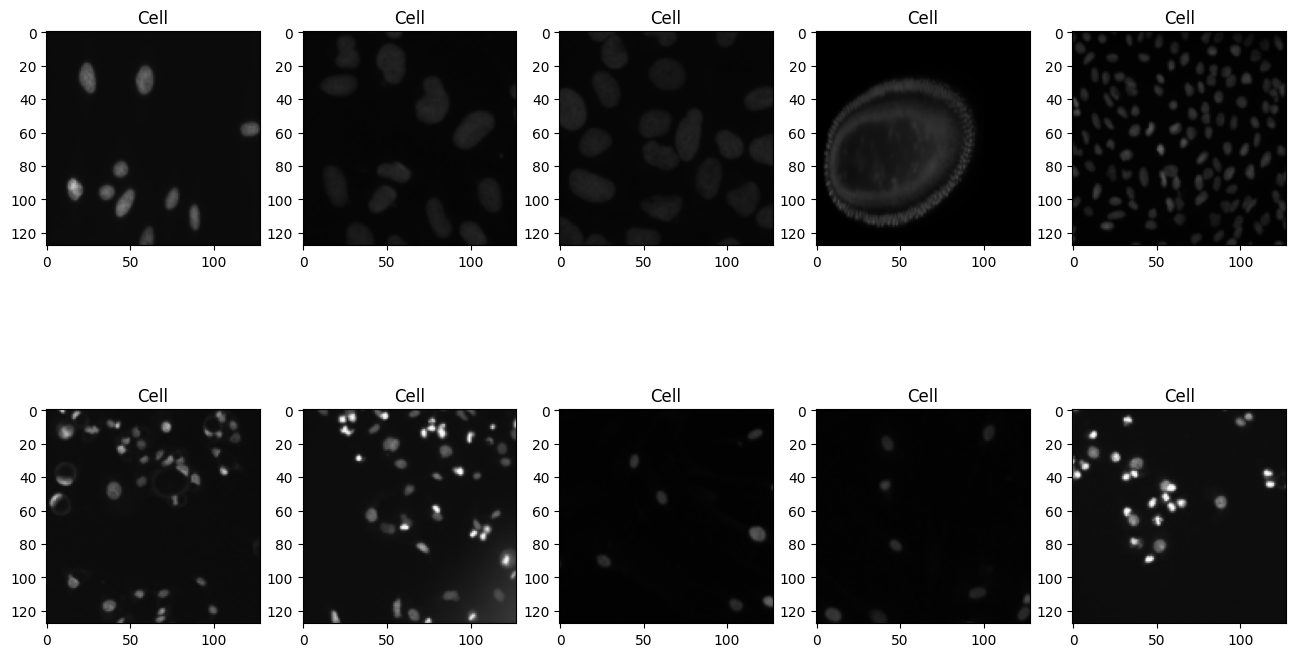

In [29]:
import cv2
def  plot_random(X_train, num = 5):
    indices = np.random.choice(len(X_train[0]),num*2,replace=False)

    plt.figure(figsize=(16,9))
    for i in range(num * 2): ## matplotlib starts from 1 differently from when using python
        plt.subplot(2,num, i+1) # 2 row with 5 columns, i want to allocate the neext image in the position i+1
        plt.title("Cell")
        img = X_train[indices[i]]
        plt.imshow(img )
    
plot_random(X_train, num = 5)

## Let's introduce the Unet architecture!

- U-Net is a convolutional neural network designed for image segmentation. It features a U-shaped architecture with a contracting path for context capture and an expansive path for precise localization. Skip connections link these paths, facilitating the combination of low and high-level features.
 - Skip connections in the U-Net architecture link the contracting path to the expansive path by concatenating corresponding feature maps from the downsampling layers directly to the upsampling layers. This concatenation happens before the convolution operations in the upsampling path. The primary purpose of these connections is to preserve spatial information that might be lost during downsampling, enabling the network to use both high-level, abstract features and low-level, detailed features when making pixel-wise predictions..
- The network uses a series of convolutions and up-convolutions, doubling feature channels during contraction and halving during expansion. U-Net is effective with limited data, widely used beyond its initial biomedical focus, and is trained end-to-end, outputting detailed, pixel-wise segmentations.

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',"precision","recall"])
model.summary()

In [23]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 512ms/step - accuracy: 0.7154 - loss: 0.6450 - precision: 0.3297 - recall: 0.0849 - val_accuracy: 0.7804 - val_loss: 0.4263 - val_precision: 0.9823 - val_recall: 0.0538
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 487ms/step - accuracy: 0.7939 - loss: 0.3908 - precision: 0.7940 - recall: 0.1878 - val_accuracy: 0.9117 - val_loss: 0.2114 - val_precision: 0.8193 - val_recall: 0.7940
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - accuracy: 0.9238 - loss: 0.2040 - precision: 0.8640 - recall: 0.8346 - val_accuracy: 0.9365 - val_loss: 0.1538 - val_precision: 0.8806 - val_recall: 0.8400
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step - accuracy: 0.9420 - loss: 0.1546 - precision: 0.9044 - recall: 0.8609 - val_accuracy: 0.9342 - val_loss: 0.2752 - val_precision: 0.8972 - val_recall: 0.8090
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 486ms/step - accuracy: 0.9460 - loss: 0.1398 - precision: 0.9092 - recall: 0.8664 - val_accuracy: 0.9461 - val_los

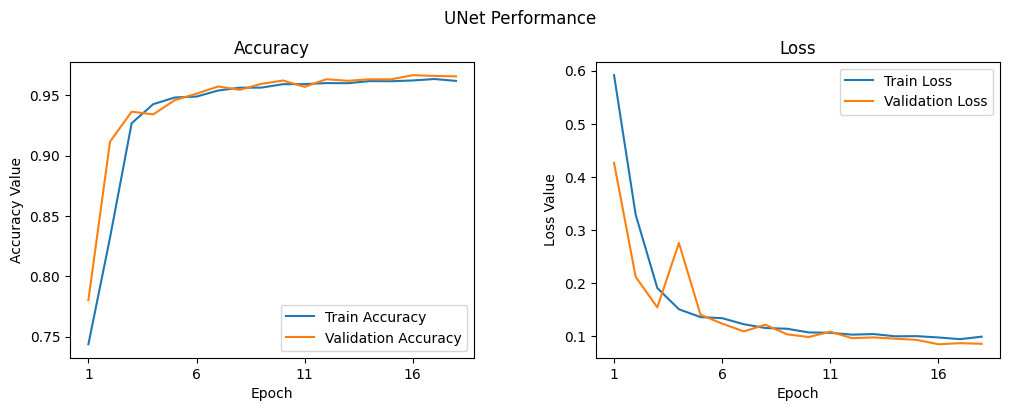

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('UNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(results.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, results.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, results.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, results.history['loss'], label='Train Loss')
ax2.plot(epoch_list, results.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Evaluation!

In [30]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


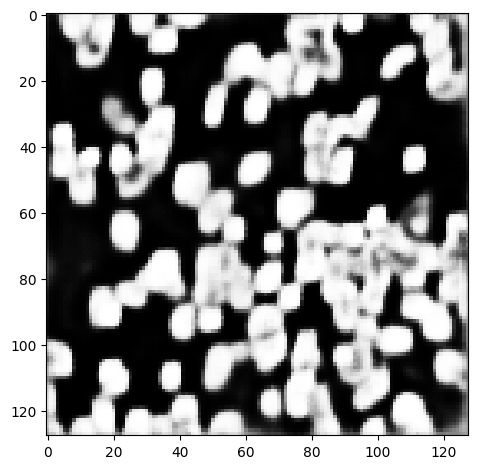

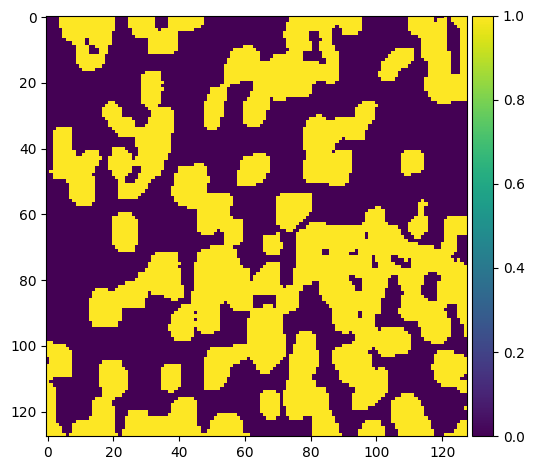

In [32]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(preds_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

# Some checks!

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step


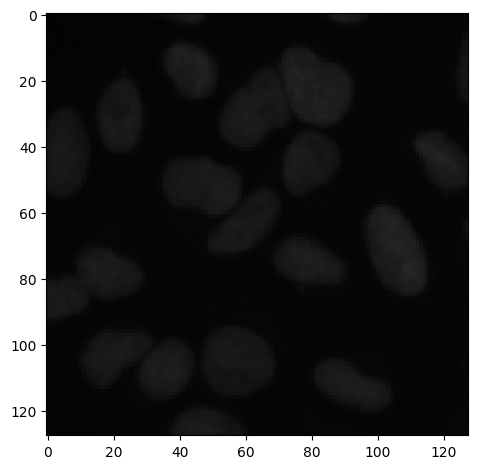

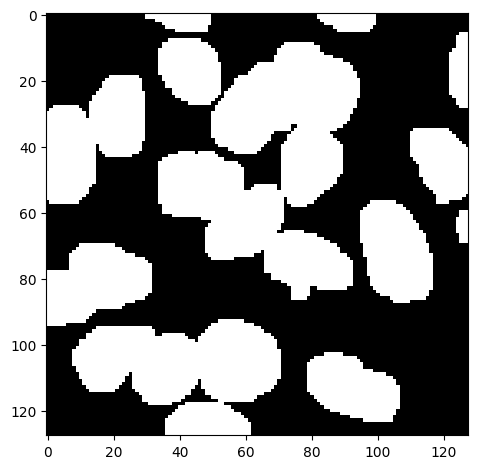

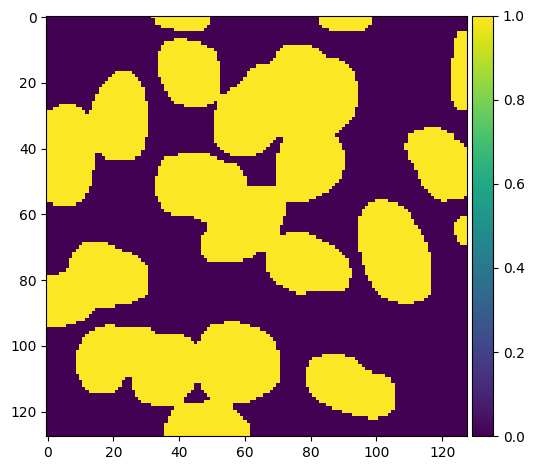

In [33]:
preds_train = model.predict(X_train, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()